<a href="https://colab.research.google.com/github/Amrutha369/voice-spoofing-detection/blob/main/voice_spoofing_detection_adaboost_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikeras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow-io
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import seaborn as sns
import joblib
from IPython.display import Audio
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 6.5 MB/s eta 0:00:00


In [ ]:
# Audio params
SAMPLE_RATE = 16000
DURATION = 20.0 # duration in second
AUDIO_LEN = int(SAMPLE_RATE * DURATION)

# Spectrogram params
N_MELS = 128 # freq axis
N_FFT = 2048
SPEC_WIDTH = 256 # time axis
HOP_LEN = 512 # non-overlap region
FMAX = SAMPLE_RATE//2 # max frequency

# CNN params
NUM_CLASSES = 2 # bonafide or spoof
BATCH_SIZE = 32 # adjust based on your memory
EPOCHS = 100 # adjust based on your time
LEARNING_RATE = 0.0001 # adjust based on your model performance
N_ESTIMATORS = 10
RANDOM_STATE = 42

In [ ]:
# Directory and protocol definitions
base_path = '/content/drive/MyDrive/dataset/LA'
protocol_dir = os.path.join(base_path, 'ASVspoof2019_LA_cm_protocols')
train_dir = os.path.join(base_path, 'ASVspoof2019_LA_train', 'flac')
dev_dir = os.path.join(base_path, 'ASVspoof2019_LA_dev', 'flac')
eval_dir = os.path.join(base_path, 'ASVspoof2019_LA_eval', 'flac')

In [ ]:
# The function to form the full path of a file.
def get_file_path(directory, filename):
    return os.path.join(directory, f'{filename}.flac')

In [ ]:
# Function to read the dataset
def read_dataset(protocol_path, directory):
    """Reads the dataset from a protocol file and returns a DataFrame."""
    df = pd.read_csv(protocol_path, sep=' ', header=None, names=['speaker_id', 'filename', 'system_id', 'null', 'class_name'])
    df['filepath'] = df['filename'].apply(lambda x: get_file_path(directory, x))
    df.drop('null', axis=1, inplace=True)
    df.dropna(inplace=True)
    return df

# Function to convert class_name to integer
def label_to_int(class_name):
    if class_name == 'bonafide':
        return 0
    else:
        return 1

# Add target column and subset to DataFrame
def add_columns(df, subset):
    df['target'] = df['class_name'].apply(label_to_int)
    df['subset'] = subset
    return df

# Take samples from each DataFrame by a different number
def sample_data(df, n_bonafide, n_spoof):
    bonafide = df[df['class_name'] == 'bonafide'].head(n_bonafide)
    spoof = df[df['class_name'] != 'bonafide'].head(n_spoof)
    return pd.concat([bonafide, spoof])

In [ ]:
# Create DataFrames for each dataset
train_df = read_dataset(os.path.join(protocol_dir, 'ASVspoof2019.LA.cm.train.trn.txt'), train_dir)
dev_df = read_dataset(os.path.join(protocol_dir, 'ASVspoof2019.LA.cm.dev.trl.txt'), dev_dir)
eval_df = read_dataset(os.path.join(protocol_dir, 'ASVspoof2019.LA.cm.eval.trl.txt'), eval_dir)

# Add columns to each DataFrame
train_df = add_columns(train_df, 'train')
dev_df = add_columns(dev_df, 'dev')
eval_df = add_columns(eval_df, 'eval')

# Take samples from each DataFrame by a different number
train_df = sample_data(train_df, 5, 5)
dev_df = sample_data(dev_df, 5, 5)
eval_df = sample_data(eval_df, 5, 5)

In [ ]:
#Merging the three dataframes into one dataframe
data_df = pd.concat([train_df, dev_df, eval_df], ignore_index=True)

In [ ]:
data_df.head(len(data_df))

,speaker_id,filename,system_id,class_name,filepath,target,subset
0,LA_0079,LA_T_1138215,-,bonafide,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,0,train
1,LA_0079,LA_T_1271820,-,bonafide,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,0,train
2,LA_0079,LA_T_1272637,-,bonafide,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,0,train
3,LA_0079,LA_T_1276960,-,bonafide,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,0,train
4,LA_0079,LA_T_1341447,-,bonafide,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,0,train
5,LA_0079,LA_T_1004644,-,spoof,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,1,train
6,LA_0079,LA_T_1056709,-,spoof,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,1,train
7,LA_0079,LA_T_1195221,-,spoof,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,1,train
8,LA_0079,LA_T_1265032,-,spoof,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,1,train
9,LA_0079,LA_T_1287124,-,spoof,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,1,train


In [ ]:
# Function to read an audio file and convert it into a spectrogram
def audio_to_spectrogram(filepath):
    # Reading the audio file
    audio = tfio.audio.AudioIOTensor(filepath)

    # Taking audio samples and converting them to float32
    audio_slice = audio.to_tensor()
    audio_tensor = tf.squeeze(audio_slice, axis=[-1])
    audio_tensor = tf.cast(audio_tensor, tf.float32)

    # Normalizing the audio
    tensor = tf.math.divide(
        tf.subtract(
            audio_tensor,
            tf.reduce_min(audio_tensor)
        ),
        tf.subtract(
            tf.reduce_max(audio_tensor),
            tf.reduce_min(audio_tensor)
        )
    )

    # Converting audio to spectrogram
    spectrogram = tfio.audio.spectrogram(
        tensor,
        nfft=N_FFT,
        window=N_FFT,
        stride=HOP_LEN
    )

    # Converting spectrogram to Mel scale
    mel_spectrogram = tfio.audio.melscale(
        spectrogram,
        rate=SAMPLE_RATE,
        mels=N_MELS,
        fmin=0,
        fmax=FMAX
    )

    # Converting Mel scale to decibels
    mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)

    # Adding channel dimension
    mel_spectrogram = tf.expand_dims(mel_spectrogram, axis=-1)

    # Resizing spectrogram to the specified size
    image = tf.image.resize(mel_spectrogram, [SPEC_WIDTH, N_MELS])

    return image

# Adding the spectrogram column to the DataFrame
data_df['spectrogram'] = data_df['filepath'].apply(audio_to_spectrogram)


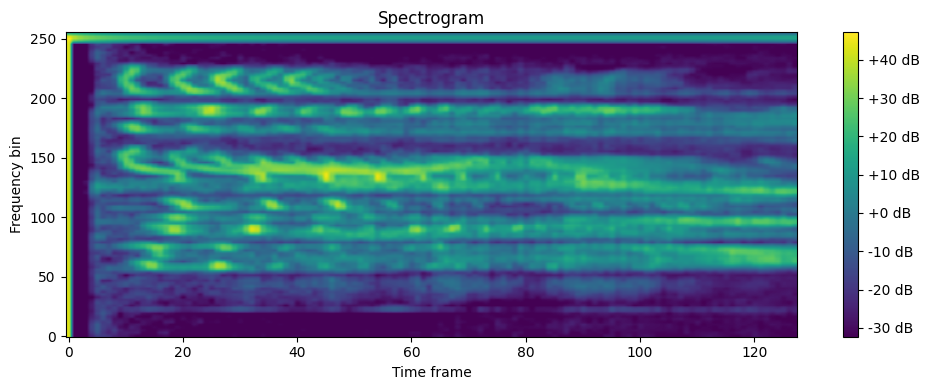

The size of the spectrogram is: (256, 128, 1)


In [ ]:
# Selecting a spectrogram from the DataFrame
first_spectrogram = data_df.loc[4, 'spectrogram']

# Using the imshow function to display the spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(tf.squeeze(first_spectrogram), aspect='auto', origin='lower')
plt.title('Spectrogram')
plt.ylabel('Frequency bin')
plt.xlabel('Time frame')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()
print("The size of the spectrogram is:", first_spectrogram.shape)


In [ ]:
# Splitting the data based on the 'subset' column
train_data = data_df[data_df['subset'] == 'train']
dev_data = data_df[data_df['subset'] == 'dev']
eval_data = data_df[data_df['subset'] == 'eval']

# Converting the list of spectrograms into NumPy arrays
X_train = np.stack(train_data['spectrogram'].to_numpy())
X_dev = np.stack(dev_data['spectrogram'].to_numpy())
X_eval = np.stack(eval_data['spectrogram'].to_numpy())

# Converting target into NumPy arrays
y_train = train_data['target'].to_numpy()
y_dev = dev_data['target'].to_numpy()
y_eval = eval_data['target'].to_numpy()


In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_dev shape: {X_dev.shape}")
print(f"y_dev shape: {y_dev.shape}")
print(f"X_eval shape: {X_eval.shape}")
print(f"y_eval shape: {y_eval.shape}")

X_train shape: (10, 256, 128, 1)
y_train shape: (10,)
X_dev shape: (10, 256, 128, 1)
y_dev shape: (10,)
X_eval shape: (10, 256, 128, 1)
y_eval shape: (10,)


In [ ]:
# Function to create a CNN model
def create_model(input_shape):
    model = Sequential()
    # 1st conv layer
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    # 2nd conv layer
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    # 3rd conv layer
    model.add(Conv2D(32, (2, 2), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    # 4th conv layer
    model.add(Conv2D(64, (2, 2), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    # Additional dense layer
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(1, activation='sigmoid'))

    # Creating a new optimizer with the desired learning rate
    optimizer=tf.keras.optimizers.RMSprop(learning_rate = LEARNING_RATE)

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Creating the model
keras_model = KerasClassifier(model=create_model((X_train.shape[1], X_train.shape[2], 1)), epochs=EPOCHS, batch_size=BATCH_SIZE)

# Applying Adaboost on the CNN model
ada_model = AdaBoostClassifier(base_estimator=keras_model, n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)


In [ ]:
# Displaying model summary.
ada_model.base_estimator.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 63, 32)       0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 127, 63, 32)       128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 61, 32)       9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 63, 31, 32)        0         
 g2D)                                                            
                                                        

In [ ]:
# Training the model.
_ =ada_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.1300 - accuracy: 0.5000
Epoch 2/100
1/1 [==============================] - 0s 464ms/step - loss: 0.0369 - accuracy: 0.8000
Epoch 3/100
1/1 [==============================] - 0s 429ms/step - loss: 0.0487 - accuracy: 0.7000
Epoch 4/100
1/1 [==============================] - 0s 442ms/step - loss: 0.0706 - accuracy: 0.6000
Epoch 5/100
1/1 [==============================] - 0s 416ms/step - loss: 0.0126 - accuracy: 1.0000
Epoch 6/100
1/1 [==============================] - 0s 442ms/step - loss: 0.0221 - accuracy: 1.0000
Epoch 7/100
1/1 [==============================] - 0s 459ms/step - loss: 0.0146 - accuracy: 0.9000
Epoch 8/100
1/1 [==============================] - 0s 458ms/step - loss: 0.0198 - accuracy: 0.9000
Epoch 9/100
1/1 [==============================] - 0s 453ms/step - loss: 0.0084 - accuracy: 1.0000
Epoch 10/100
1/1 [==============================] - 0s 435ms/step - loss: 0.0060 - accuracy: 1.0000
Epoch 11/100

In [ ]:
# Calculating accuracy on the training data.
train_accuracy = ada_model.score(X_train, y_train)
print(f"Accuracy on training data: {train_accuracy * 100:.2f}%")

# Calculating accuracy on the validation data.
val_accuracy = ada_model.score(X_dev, y_dev)
print(f'Accuracy on validation data: {val_accuracy * 100:.2f}%')

# Calculating accuracy on the evaluation data.
test_accuracy = ada_model.score(X_eval, y_eval)
print(f'Accuracy on test data: {test_accuracy * 100:.2f}%')

1/1 [==============================] - 0s 121ms/step
Accuracy on training data: 100.00%
1/1 [==============================] - 0s 116ms/step
Accuracy on validation data: 90.00%
1/1 [==============================] - 0s 134ms/step
Accuracy on test data: 80.00%


In [ ]:
# Get one bonafide file from the 'eval' subset
bonafide_file = data_df[(data_df['class_name'] == 'bonafide') & (data_df['subset'] == 'eval')].iloc[0]

# Get one spoof file from the 'eval' subset
spoof_file = data_df[(data_df['class_name'] == 'spoof') & (data_df['subset'] == 'eval')].iloc[0]

# Create spectrograms for both files
bonafide_spectrogram = audio_to_spectrogram(bonafide_file['filepath'])
spoof_spectrogram = audio_to_spectrogram(spoof_file['filepath'])
X_new = np.stack([bonafide_spectrogram, spoof_spectrogram])

# Perform prediction
y_pred = ada_model.predict(X_new)

# Create a dictionary for mapping
class_dict = {0: 'bonafide', 1: 'spoof'}

# Apply mapping to predictions
y_pred_classes = [class_dict[i] for i in y_pred]

# Print the results
for i, pred in enumerate(y_pred_classes):
    print(f"File {i+1} is {pred}")


1/1 [==============================] - 0s 37ms/step
File 1 is bonafide
File 2 is spoof


In [ ]:
import os

# Define the paths to the bonafide and spoof audio files
bonafide_file_path = "/content/drive/MyDrive/dataset/LA/ASVspoof2019_LA_train/flac/LA_T_1138215.flac"
spoof_file_path = "/content/drive/MyDrive/dataset/LA/ASVspoof2019_LA_train/flac/LA_T_1004644.flac"

# Creating spectrograms for both files
bonafide_spectrogram = audio_to_spectrogram(bonafide_file_path)
spoof_spectrogram = audio_to_spectrogram(spoof_file_path)
X_new = np.stack([bonafide_spectrogram, spoof_spectrogram])

# Performing prediction
y_pred_prob = ada_model.predict(X_new)


# Creating a dictionary for mapping
class_dict = {0: 'bonafide', 1: 'spoof'}

# Applying mapping to predictions
y_pred_classes = [class_dict[i] for i in y_pred_prob]

# Printing the results
for i, pred in enumerate(y_pred_classes):
    print(f"File {i+1} is {pred}")


1/1 [==============================] - 0s 64ms/step
File 1 is bonafide
File 2 is spoof


In [ ]:
# Making predictions on the evaluation set
y_eval_pred = ada_model.predict(X_eval)

# Calculating the classification report
report = classification_report(y_eval, y_eval_pred, target_names=class_dict.values())

# Printing the report
print(report)


1/1 [==============================] - 0s 121ms/step
              precision    recall  f1-score   support

    bonafide       1.00      0.60      0.75         5
       spoof       0.71      1.00      0.83         5

    accuracy                           0.80        10
   macro avg       0.86      0.80      0.79        10
weighted avg       0.86      0.80      0.79        10



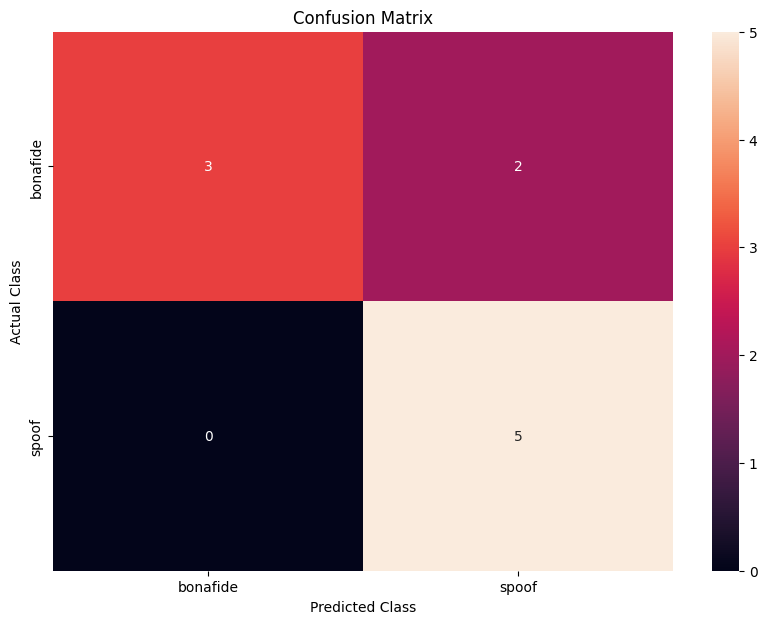

In [ ]:
# Calculating the confusion matrix
cm = confusion_matrix(y_eval, y_eval_pred)

# Creating the plot
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_dict.values(), yticklabels=class_dict.values())
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

# Displaying the plot
plt.show()
